# K Nearest Neighbor Algorithm

## 1. Download the CIFAR10 datasets, and load it

You have two ways to download the CIFAR10 datasets:
- cd the path to './CIFAR10/datasets/', and run the 'get_datasets.sh'. Then it will automatically download the datasets and decompress it.
- Enter the CIFAR10 website: http://www.cs.toronto.edu/~kriz/cifar.html and manually download the python version. Then put the datasets in local folder './CIFAR10/datasets/'.

The CIFAR10 datasets named 'cifar-10-batches-py/'

### Setup code

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from CIFAR10.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Load the CIFAR10 data

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'CIFAR10/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Show some CIFAR10 images

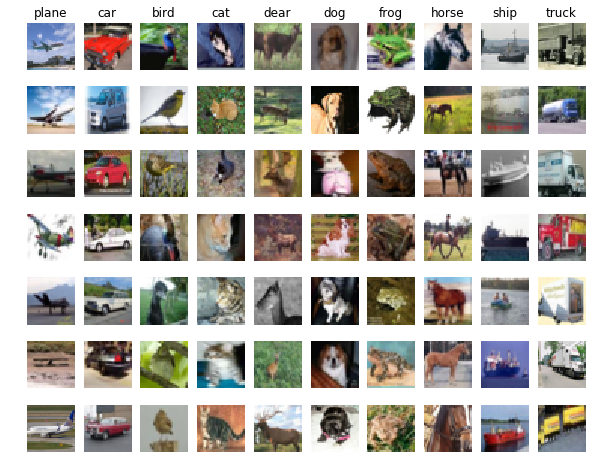

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'dear', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
num_each_class = 7

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, num_each_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + (y + 1)
        plt.subplot(num_each_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Subsample the data for more efficient code execution

In [4]:
# train numbers
num_train = 5000
mask = range(num_train)
X_train = X_train[mask]
y_train = y_train[mask]

# test numbers
num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
# change 4D to 2D, like (5000, 32, 32, 3) -> (5000, 3072)
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (5000, 3072)
X_test shape:  (500, 3072)


## 2. Define a K Nearest Neighbor Class

In [6]:
class KNearestNeighbor(object):
    """a KNN classifier with L2 distance"""
    def __init__(self):
        pass
    
    def train(self, X, y):
        """
        Train the classifier. This is just memorizing all the training data.
        Inputs:
        - X: A numpy array of shape (num_train, D) containing the training data
          consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (num_train,) containing the training labels, 
          where y[i] is the label for X[i].
        """
        self.X_train = X
        self.y_train = y
    
    def predict(self, X, k = 1, num_loops = 0):
        """
        Test the classifier. 
        Inputs:
        - X: A numpy array of shape (num_test, D) containing the test data
          consisting of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.
        - num_loops: Determine whether use for-loop to calculate L2 distance
          between the train points and test points
        Return:
        - pred_y: Predict output y
        """
        # calculate the L2 distance between test X and train X
        if num_loops == 0:
            # no for-loop, vectorized
            dists = self.cal_dists_no_loop(X)
        elif num_loops == 1:
            # one for-loop, half-vectorized
            dists = self.cal_dists_one_loop(X)
        elif num_loops == 2:
            # two for-loop, no vectorized
            dists = self.cal_dists_two_loop(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)

        # predict the labels
        num_test = X.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            dists_k_min = np.argsort(dists[i])[:k]    # the closest k distance loc 
            close_y = self.y_train[dists_k_min]    # the closest k distance ,all labels
            y_pred[i] = np.argmax(np.bincount(close_y))    # [0,3,1,3,3,1] -> 3　as y_pred[i]
        
        return y_pred
    
    def cal_dists_no_loop(self, X):
        """
        Calculate the distance with no for-loop
        Input:
        - X: A numpy array of shape (num_test, D) containing the test data
          consisting of num_test samples each of dimension D.
        Return:
        - dists: The distance between test X and train X
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        # (X - X_train)*(X - X_train) = -2X*X_train + X*X + X_train*X_train
        d1 = np.multiply(np.dot(X, self.X_train.T), -2)    # shape (num_test, num_train)
        d2 = np.sum(np.square(X), axis=1, keepdims=True)    # shape (num_test, 1)
        d3 = np.sum(np.square(self.X_train), axis=1)    # shape (1, num_train)
        dists = np.sqrt(d1 + d2 + d3)
        
        return dists
    
    def cal_dists_one_loop(self, X):
        """
        Calculate the distance with one for-loop
        Input:
        - X: A numpy array of shape (num_test, D) containing the test data
          consisting of num_test samples each of dimension D.
        Return:
        - dists: The distance between test X and train X
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            dists[i] = np.sqrt(np.sum(np.square(self.X_train - X[i]), axis=1))
        
        return dists
    
    def cal_dists_two_loop(self, X):
        """
        Calculate the distance with two for-loop
        Input:
        - X: A numpy array of shape (num_test, D) containing the test data
          consisting of num_test samples each of dimension D.
        Return:
        - dists: The distance between test X and train X
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            for j in range(num_train):
                dists[i][j] = np.sqrt(np.sum(np.square(X[i] - self.X_train[j])))
        
        return dists   

## 3. Train and Test

### Create a KNN classifier instance

In [7]:
KNN = KNearestNeighbor()
KNN.train(X_train, y_train)

### Compare the value of distance_computation by no loop, one-loop and two-loop

In [8]:
dists_no_loop = KNN.cal_dists_no_loop(X_test)
dists_one_loop = KNN.cal_dists_one_loop(X_test)
dists_two_loop = KNN.cal_dists_two_loop(X_test)
diff1 = np.linalg.norm(dists_no_loop - dists_one_loop)
diff2 = np.linalg.norm(dists_no_loop - dists_two_loop)
print('The difference between no-loop and one-loop is: %f' % diff1)
print('The difference between no-loop and two-loop is: %f' % diff2)
if diff1 < 0.001 and diff2 < 0.001:
    print('Good, the distance matrices are the same!')
else:
    print('Oh, the distance matrices are different')

The difference between no-loop and one-loop is: 0.000000
The difference between no-loop and two-loop is: 0.000000
Good, the distance matrices are the same!


### Compare the speed of distance_computation by no-loop, one-loop and two-loop

In [9]:
def time_func(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    
    t_st = time.time()
    f(*args)
    t_ed = time.time()
    
    return t_ed - t_st

# no-loop
no_loop_time = time_func(KNN.cal_dists_no_loop, X_test)
print('No loop time: %f seconds' % no_loop_time)
one_loop_time = time_func(KNN.cal_dists_one_loop, X_test)
print('One loop time: %f seconds' % one_loop_time)
two_loop_time = time_func(KNN.cal_dists_two_loop, X_test)
print('Two loop time: %f seconds' % two_loop_time)
    

No loop time: 0.185584 seconds
One loop time: 27.167150 seconds
Two loop time: 35.573068 seconds


So the fully vectorized implementation is fastest!

### Predict test dataset 

In [10]:
# k = 1
y_pred = KNN.predict(X_test, k=1)
num_correct = np.sum(y_pred == y_test)
accuracy = np.mean(y_pred == y_test)
print('Correct %d/%d: The accuracy is %f' % (num_correct, X_test.shape[0], accuracy))

Correct 137/500: The accuracy is 0.274000


In [11]:
# k = 5
y_pred = KNN.predict(X_test, k=5)
num_correct = np.sum(y_pred == y_test)
accuracy = np.mean(y_pred == y_test)
print('Correct %d/%d: The accuracy is %f' % (num_correct, X_test.shape[0], accuracy))

Correct 139/500: The accuracy is 0.278000


## 3. Cross Validation

We don't sure which **k** value is the best choice. So We will now determine the best value of this hyperparameter with cross-validation. 

In [12]:
num_folds = 5    # split the training dataset to 5 parts
k_classes = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]    # all k, determine the best k

# Split up the training data into folds
X_train_folds = []
y_train_folds = []
X_train_folds = np.split(X_train, num_folds)
y_train_folds = np.split(y_train, num_folds)

# A dictionary holding the accuracies for different values of k
k_accuracy = {}

for k in k_classes:
    accuracies = []
    #knn = KNearestNeighbor()
    for i in range(num_folds):
        Xtr = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:])
        ytr = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:])
        Xcv = X_train_folds[i]
        ycv = y_train_folds[i]
        KNN.train(Xtr, ytr)
        ycv_pred = KNN.predict(Xcv, k=k, num_loops=0)
        accuracy = np.mean(ycv_pred == ycv)
        accuracies.append(accuracy)
    k_accuracy[k] = accuracies

# Print the accuracy
for k in k_classes:
    for i in range(num_folds):
        print('k = %d, fold = %d, accuracy: %f' % (k, i+1, k_accuracy[k][i]))

k = 1, fold = 1, accuracy: 0.263000
k = 1, fold = 2, accuracy: 0.257000
k = 1, fold = 3, accuracy: 0.264000
k = 1, fold = 4, accuracy: 0.278000
k = 1, fold = 5, accuracy: 0.266000
k = 3, fold = 1, accuracy: 0.239000
k = 3, fold = 2, accuracy: 0.249000
k = 3, fold = 3, accuracy: 0.240000
k = 3, fold = 4, accuracy: 0.266000
k = 3, fold = 5, accuracy: 0.254000
k = 5, fold = 1, accuracy: 0.248000
k = 5, fold = 2, accuracy: 0.266000
k = 5, fold = 3, accuracy: 0.280000
k = 5, fold = 4, accuracy: 0.292000
k = 5, fold = 5, accuracy: 0.280000
k = 8, fold = 1, accuracy: 0.262000
k = 8, fold = 2, accuracy: 0.282000
k = 8, fold = 3, accuracy: 0.273000
k = 8, fold = 4, accuracy: 0.290000
k = 8, fold = 5, accuracy: 0.273000
k = 10, fold = 1, accuracy: 0.265000
k = 10, fold = 2, accuracy: 0.296000
k = 10, fold = 3, accuracy: 0.276000
k = 10, fold = 4, accuracy: 0.284000
k = 10, fold = 5, accuracy: 0.280000
k = 12, fold = 1, accuracy: 0.260000
k = 12, fold = 2, accuracy: 0.295000
k = 12, fold = 3, acc

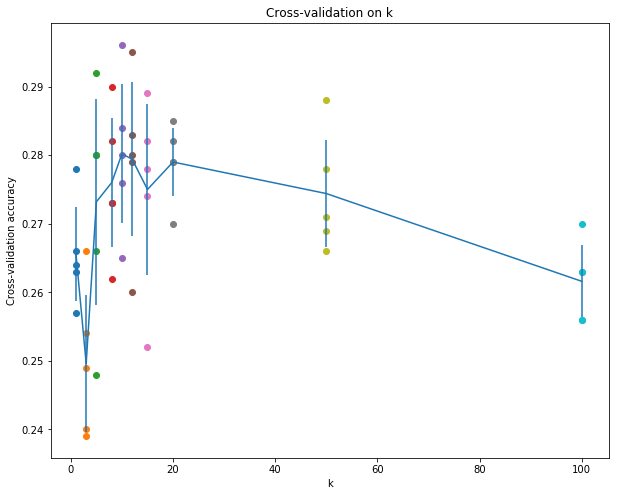

In [13]:
# Plot the cross validation
for k in k_classes:
    plt.scatter([k] * num_folds, k_accuracy[k])
# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = [np.mean(k_accuracy[k]) for k in k_accuracy]
accuracies_std = [np.std(k_accuracy[k]) for k in k_accuracy]
plt.errorbar(k_classes, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [14]:
# Choose the best k
best_k = k_classes[np.argmax(accuracies_mean)]
# Use the best k, and test it on the test data
KNN = KNearestNeighbor()
KNN.train(X_train, y_train)
y_pred = KNN.predict(X_test, k=best_k, num_loops=0)
num_correct = np.sum(y_pred == y_test)
accuracy = np.mean(y_pred == y_test)
print('Correct %d/%d: The accuracy is %f' % (num_correct, X_test.shape[0], accuracy))

Correct 141/500: The accuracy is 0.282000
